In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

In [83]:
# Preparations
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
%run ../../core/aeff_calculations.py


icecube (full) astro events: 3190.486388135174
Below -4.59 deg, A_eff is set to 0
icecube (upgoing) astro events: 3089.2566985613294
icecube (after rotation, upgoing) astro events: 3089.306444551753
Saving up-going effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_upgoing.pckl
starting full effective area calculation...
icecube (after rotation, full) astro events: 3190.5111286114948
Saving full effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_full.pckl
finished!


In [84]:


# # calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# # run these every time there are updates to resolution, binning, or mephistograms
# # load and prepare the energy and angular resolutions
# %run ../../core/resolution.py


In [97]:
# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

Update the binning for a_eff ... new interpolation
140 log_10(energy) bins
501 declination bins
Update the binning for a_eff ... new interpolation
140 log_10(energy) bins
501 declination bins
Saving background flux to:  /home/hpc/capn/capn102h/repos/Plenum/local/atmospheric_background_daemonflux_MH.pckl and /home/hpc/capn/capn102h/repos/Plenum/local/atmospheric_background_daemonflux_multi-det.pckl


# Imports

In [2]:
from aeff_calculations import *
import settings as st
from settings import poles
from collections import namedtuple
from fluxes import astro_flux, ngc_flux, txs_flux
from tools import read_effective_area
import pickle
from os.path import join

import numpy as np
from matplotlib.colors import LogNorm
from settings import *  # contains all flux parameters

from aeff_calculations import calc_aeff_factor
from fluxes import astro_flux, ngc_flux, PL_flux

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


# load prepared aeffs

In [3]:
with open(join(LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

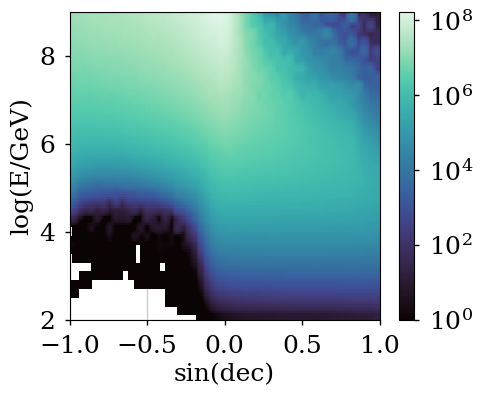

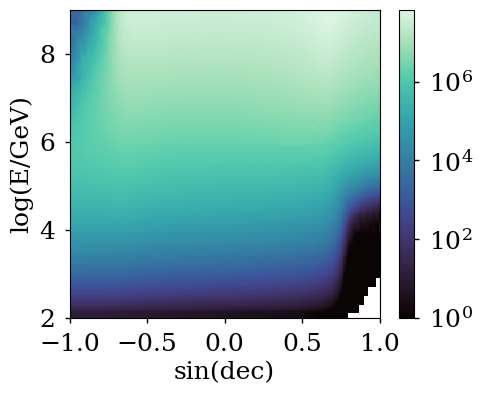

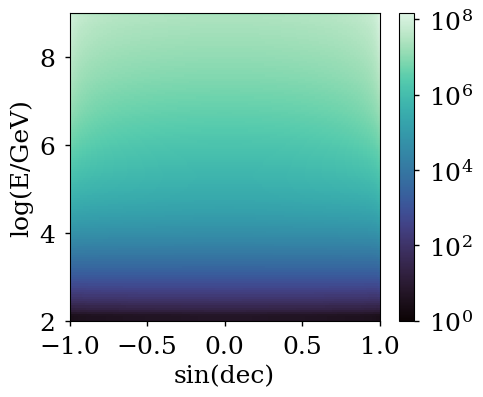

In [106]:
aeff_2d["IceCube"].plot(norm=LogNorm(vmin=1))
aeff_2d["P-ONE"].plot(norm=LogNorm(vmin=1))
aeff_2d["Horizon"].plot(norm=LogNorm(vmin=1))

In [107]:
aeff_2d_base, logE_bins_old, _, sindec_bins_old = get_aeff_and_binnings("full")

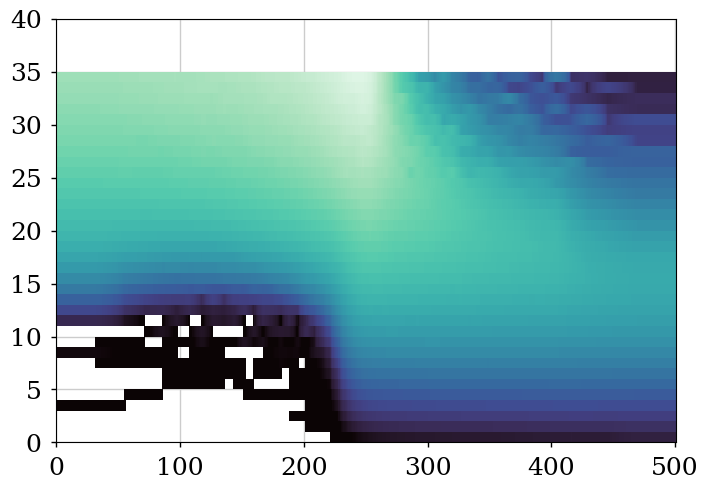

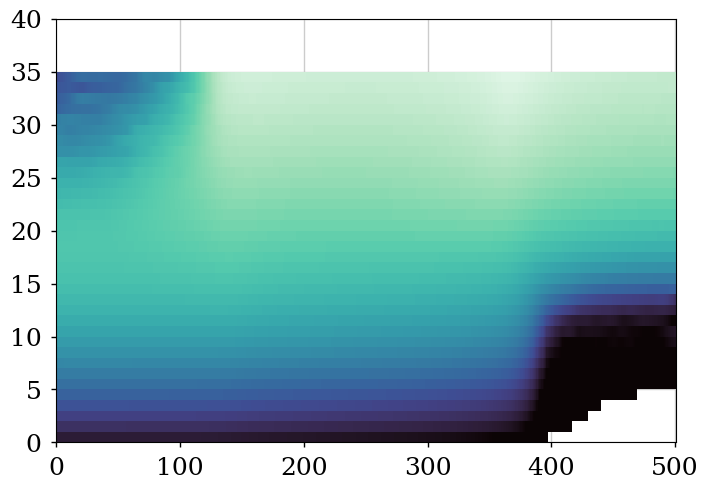

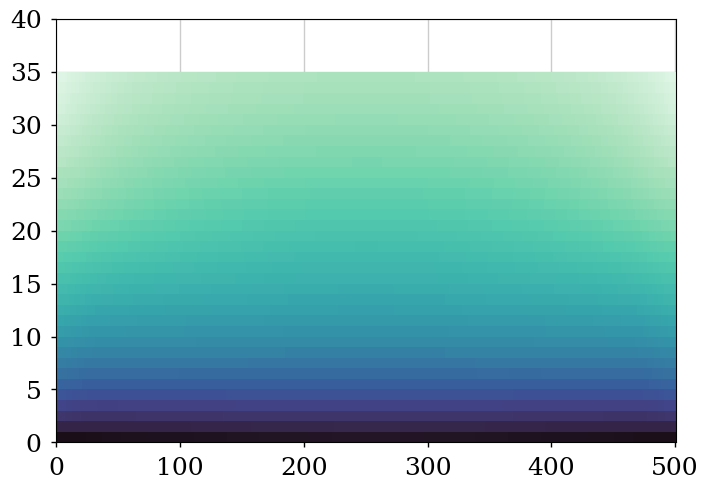

In [108]:
plt.figure()
plt.pcolormesh(aeff_2d_base["IceCube"], norm=LogNorm(vmin=1))
plt.figure()
plt.pcolormesh(aeff_2d_base["P-ONE"], norm=LogNorm(vmin=1))
plt.figure()
plt.pcolormesh(aeff_2d_base["Horizon"], norm=LogNorm(vmin=1))

## diffuse comparison

In [ ]:
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

In [131]:
diffuse_config = dict(
    sindec_mids=st.sindec_mids,
    sindec_width=np.ones_like(st.sindec_width)/len(st.sindec_width)*2,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    diff_or_ps="diff",
)

aeff_factor = calc_aeff_factor(aeff_2d["IceCube"], **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)
print(np.sum(k_s))

2949.553781179752


In [ ]:


diffuse_config = dict(
    sindec_mids=get_mids(sindec_bins_old),
    sindec_width=np.diff(sindec_bins_old ),
    livetime=LIVETIME,
    ewidth=np.diff(10**logE_bins_old),
    diff_or_ps="diff",
)

aeff_factor = calc_aeff_factor(aeff_2d_base["IceCube"].T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    10 ** get_mids(logE_bins_old),
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))

aeff_factor = calc_aeff_factor(aeff_2d_base["Horizon"].T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    10 ** get_mids(logE_bins_old),
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))

#re-binned
diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME,
    ewidth=ewidth,
    diff_or_ps="diff",
)

aeff_factor = calc_aeff_factor(aeff_2d["IceCube"], **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))

aeff_factor = calc_aeff_factor(aeff_2d["Horizon"], **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))

Signal: 3190.511128611494
Signal: 3190.2333642500025
Signal: 3168.4339423030356
Signal: 3167.9371396027113


## ps comparison

In [110]:
flux = ngc_flux
ident = "IceCube"
# check that the bins match
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=0,
)

aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_2d[ident].bin_mids[1],
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=flux,
)
print("source events:", np.sum(k_s))

# original bins in energy
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=np.diff(np.power(10, logE_bins_old)),
    dpsi_max=0,
    grid_2d=1,
    dec=0,
)
aeff_factor_signal = calc_aeff_factor(aeff_2d_base[ident].T, **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** get_mids(logE_bins_old),
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=flux,
)
print("source events:", np.sum(k_s))


ident = "Horizon"
# check that the bins match
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=np.pi/2,
)

aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_2d[ident].bin_mids[1],
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=flux,
)
print("source events:", np.sum(k_s))


source events: 98.26451036195353
source events: 98.30736819945679
end of range
source events: 99.08762152354237


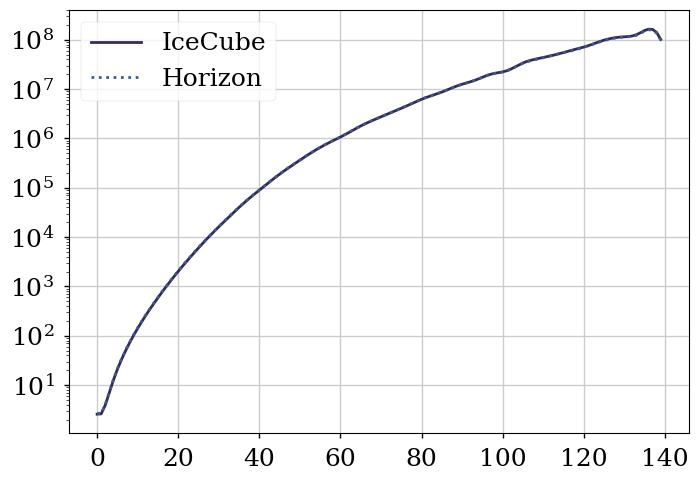

In [73]:
plt.plot(aeff_2d["IceCube"][249], label="IceCube")
plt.plot(aeff_2d["Horizon"][0], label="Horizon", ls=":")
plt.yscale("log")
plt.legend()

# acceptance event numbers

In [45]:
# ps - horizon vs pole
_nev = []
for dec in np.arcsin(np.linspace(-1, 1, num=51, endpoint=True)):
    src_config = dict(
        sindec_mids=sindec_mids,
        livetime=LIVETIME,
        ewidth=ewidth,
        dpsi_max=0,
        grid_2d=1,
        diff_or_ps="ps",
        dec=dec,
    )

    aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **src_config)

    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        energy_resolution=None,
        phi_scaling=1,
        flux_shape=txs_flux,
    )
    _nev.append(np.sum(k_s))


_nev = np.array(_nev)

low end range
end of range


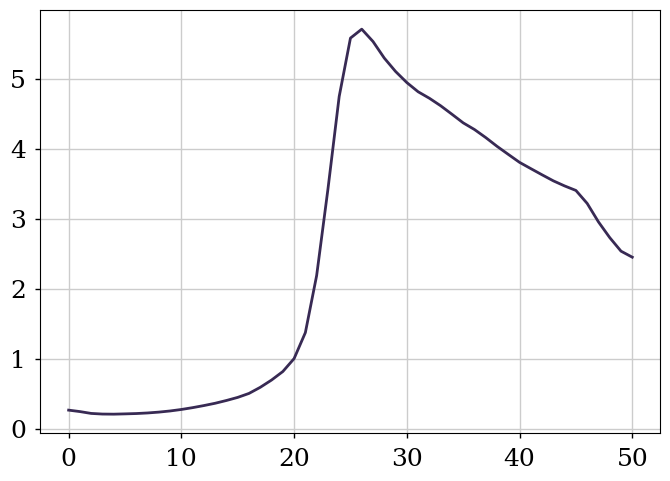

In [46]:
plt.plot(_nev)

# Testing

In [4]:
public_data_aeff = read_effective_area()

In [5]:
public_data_aeff

,logE_nu_min,logE_nu_max,Dec_nu_min,Dec_nu_max,A_eff
0,2.0,2.2,-90.00,-73.74,0.00
1,2.2,2.4,-90.00,-73.74,0.00
2,2.4,2.6,-90.00,-73.74,0.00
3,2.6,2.8,-90.00,-73.74,0.01
4,2.8,3.0,-90.00,-73.74,0.00
...,...,...,...,...,...
1995,9.0,9.2,73.74,90.00,0.00
1996,9.2,9.4,73.74,90.00,0.00
1997,9.4,9.6,73.74,90.00,0.00
1998,9.6,9.8,73.74,90.00,0.00


In [6]:
sindec_bins = np.unique(
    np.sin(np.deg2rad([public_data_aeff.Dec_nu_min, public_data_aeff.Dec_nu_max]))
)
sindec_bins = np.round(sindec_bins, 2)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

log_ebins = np.unique([public_data_aeff.logE_nu_min, public_data_aeff.logE_nu_max])
log_emids = get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = np.power(10, get_mids(log_ebins))
ewidth = np.diff(ebins)
aeff_icecube_full = (
        public_data_aeff["A_eff"].values.reshape(len(sindec_mids), len(emids)).T
    )

In [10]:
_factor = (
    aeff_icecube_full.T
    * sindec_width[:, np.newaxis]
    * ewidth
    * np.sum(ra_width)
    * LIVETIME
)
flux = _factor * st.PHI_ASTRO * (emids/st.E_NORM) ** (-2) #(-st.GAMMA_ASTRO)

In [9]:
st.GAMMA_ASTRO

2.37

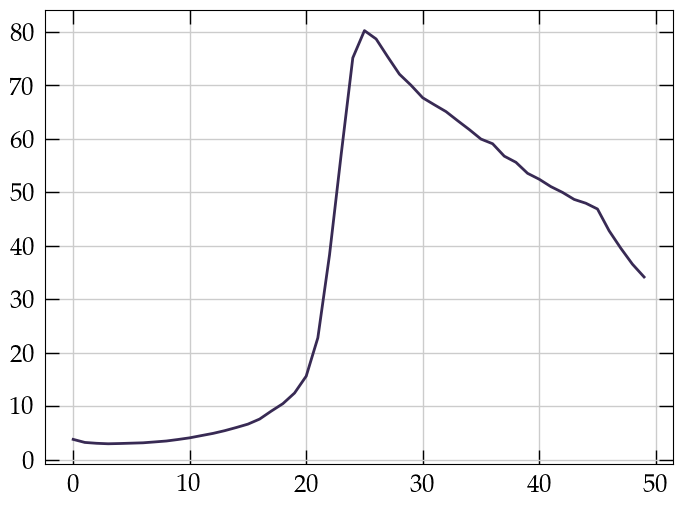

In [11]:
# plt.pcolormesh(flux, norm=LogNorm())

plt.figure()
plt.plot(flux.sum(axis=1))

In [7]:
np.sum(flux)

3190.486388135174

In [14]:
min_idx = np.searchsorted(sindec_mids, np.sin(np.deg2rad(-5)))
print(
    f"Below {np.rad2deg(np.arcsin(sindec_bins[min_idx])):1.2f} deg, A_eff is set to 0"
)
aeff_icecube_upgoing = np.copy(aeff_icecube_full)
aeff_icecube_upgoing[:, :min_idx] = 0

Below -4.59 deg, A_eff is set to 0


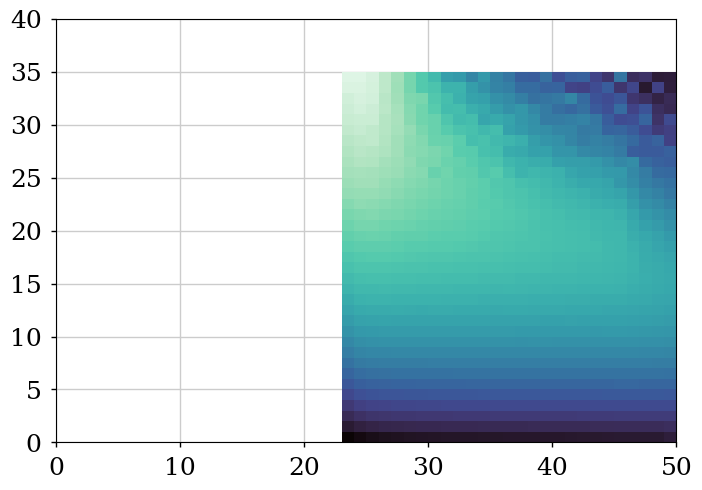

In [15]:
plt.pcolormesh(aeff_icecube_upgoing, norm=LogNorm())

# event numbers

In [10]:
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME,
    ewidth=ewidth,
    diff_or_ps="diff",
)

aeff_factor = calc_aeff_factor(aeff_icecube_full.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))

Signal: 3190.486388135174


# toy setup

In [12]:
import settings as st

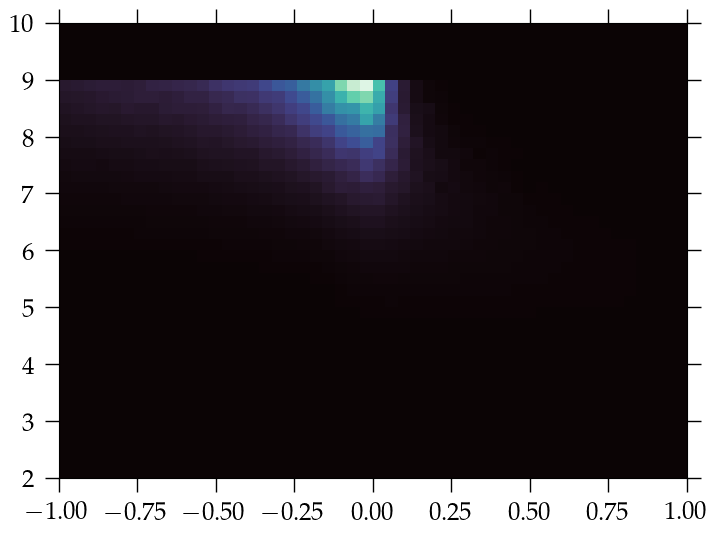

In [45]:
toy_aeff = aeff_icecube_full #np.zeros_like(aeff_icecube_full)
# toy_aeff[:, 25:] = 1
plt.pcolormesh(sindec_mids, log_emids, toy_aeff)
plt.gca().tick_params(axis="both", direction="out")

In [46]:
nside = 2**8
npix = hp.nside2npix(nside)
pix = np.arange(npix)
hp_angles = hp.pix2ang(nside, pix)

# binning setup
_azi = hp_angles[1]
_zen = hp_angles[0] - np.pi / 2

# for rotation
hp_coords = SkyCoord(_azi * u.radian, _zen * u.radian, frame="icrs")

# for integration
pp, tt = np.meshgrid(st.ra_mids, np.arcsin(st.sindec_mids))
eq_coords = SkyCoord(pp * u.radian, tt * u.radian, frame="icrs")
grid2d, _ = setup_aeff_grid(
    toy_aeff,
    sindec_mids,
    st.ra_mids,
    st.ra_width,
    local=True,
    log_int=False,
)
toy_aeff_equator = earth_rotation(
    0 * u.deg,
    0 * u.deg,
    eq_coords,
    hp_coords,
    grid2d,
    ra_width,
    log_aeff=False,
)

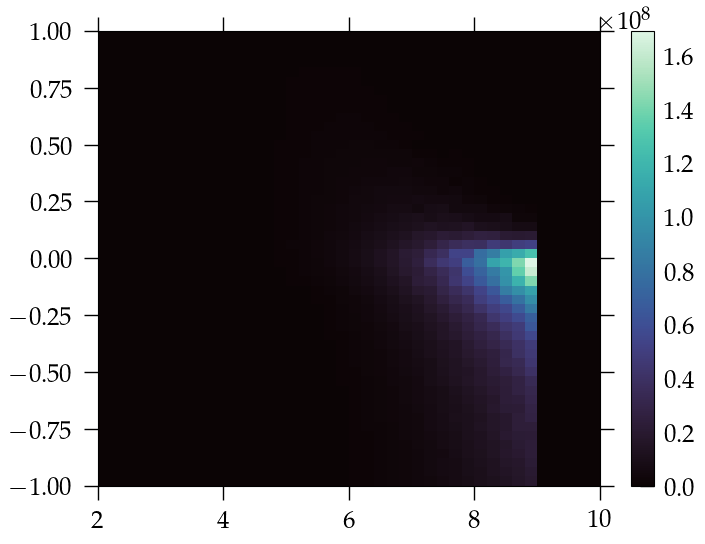

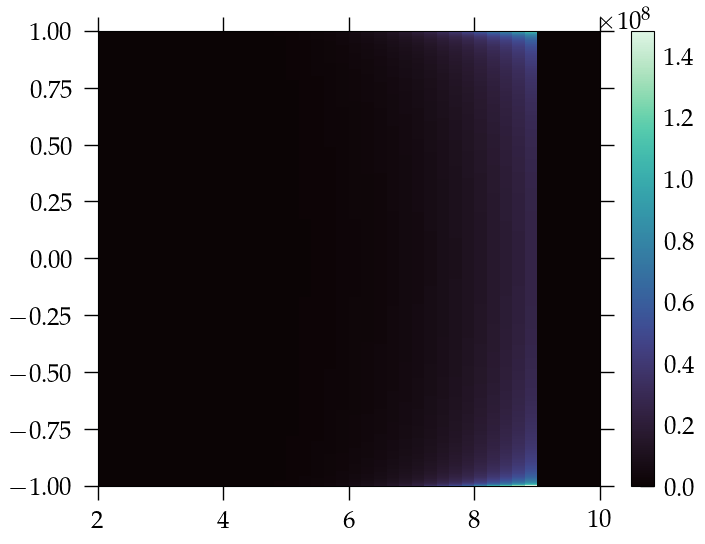

In [48]:
plt.figure()
plt.pcolormesh(
    log_emids,
    sindec_mids,
    toy_aeff.T,
)  # norm=LogNorm())
plt.gca().tick_params(axis="both", direction="out")
plt.colorbar()

plt.figure()
plt.pcolormesh(
    log_emids,
    st.sindec_mids,
    toy_aeff_equator.T,
    # np.abs(toy_aeff_equator.T-0.5)
    # norm=LogNorm(),
)
plt.gca().tick_params(axis="both", direction="out")
plt.colorbar()

5.920653658685032


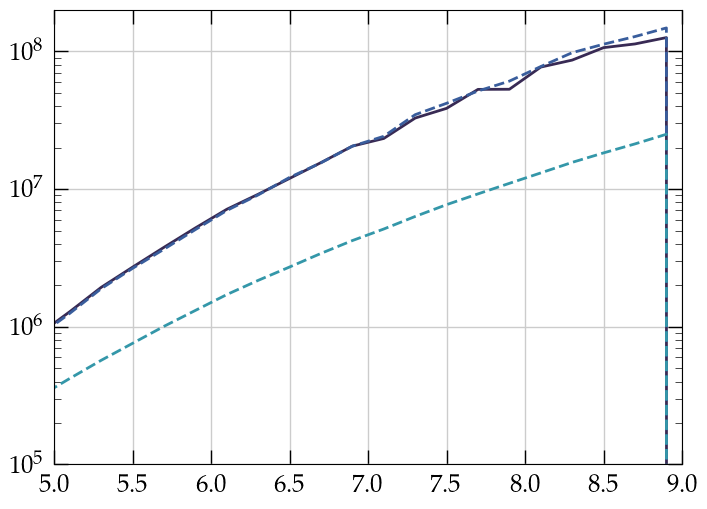

In [61]:
plt.figure()
plt.plot(log_emids, toy_aeff[:, 25])
plt.plot(log_emids, toy_aeff_equator[:, 0], ls="--")
plt.plot(log_emids, toy_aeff_equator[:, len(st.sindec_mids) // 2], ls="--")
plt.ylim(1e5, 2e8)
plt.xlim(5, 9)
plt.yscale("log")

print(
    np.max(toy_aeff_equator[:, 0])
    / np.max(toy_aeff_equator[:, len(st.sindec_mids) // 2])
)

# healpy setup

In [ ]:
import healpy as hp
nside = 2**8
npix = hp.nside2npix(nside)
print(npix)
pix = np.arange(npix)
hp_angles = hp.pix2ang(nside, pix)
print(hp_angles)

print(len(np.unique(hp_angles[0])))
print(len(np.unique(hp_angles[1])), len(hp_angles[1]))

# plt.figure()
# plt.scatter(hp_angles[1], np.cos(hp_angles[0]), s=2)

In [113]:
# fine bins in dec
_sd_bins = st.sindec_bins #np.sin(np.linspace(-np.pi / 2, np.pi / 2, 502, endpoint=True))
_sd = st.sindec_mids #get_mids(_sd_bins)
_ra_len = len(st.ra_bins) #500
_ra = st.ra_bins #np.linspace(0, 2 * np.pi, _ra_len, endpoint=True)
_ra_width = st.ra_width[0] #_ra[1] - _ra[0]
_ra_mids = st.ra_mids #get_mids(_ra)

_azi = hp_angles[1]
_zen = hp_angles[0] - np.pi / 2


grid2d, _ = setup_aeff_grid(
    aeff_icecube_full,
    sindec_mids,
    _ra_mids,
    _ra_width,
    local=True,
    log_int=False,
)
# for rotation
hp_coords = SkyCoord(_azi * u.radian, _zen * u.radian, frame="icrs")
time = Time("2025-01-01 12:00:00")

# for integration 
pp, tt = np.meshgrid(_ra_mids, np.arcsin(_sd))
eq_coords = SkyCoord(pp * u.radian, tt * u.radian, frame="icrs")


In [114]:

## horizon detector
coord_lat = 0 * u.deg
coord_lon = 215 * u.deg

loc = EarthLocation(lat=coord_lat, lon=coord_lon)

new_aeff = []

for indx in range(len(grid2d)):

    # transform integration coordinates to local frame
    local_coords = hp_coords.transform_to(AltAz(obstime=time, location=loc))

    rot_aeff = grid2d[indx]((np.sin(local_coords.alt.radian), local_coords.az.radian))
    new_aeff.append(
        hp.get_interp_val(
            rot_aeff, np.pi / 2 - eq_coords.dec.radian, np.pi - eq_coords.ra.radian
        )
    )
new_aeff = np.array(new_aeff)

## southpole detector
coord_lat = -90 * u.deg
coord_lon = 215 * u.deg

loc = EarthLocation(lat=coord_lat, lon=coord_lon)

ic_aeff = []

for indx in range(len(grid2d)):

    # transform integration coordinates to local frame
    local_coords = hp_coords.transform_to(AltAz(obstime=time, location=loc))

    rot_aeff = grid2d[indx]((np.sin(local_coords.alt.radian), local_coords.az.radian))
    ic_aeff.append(
        hp.get_interp_val(
            rot_aeff, np.pi / 2 - eq_coords.dec.radian, np.pi - eq_coords.ra.radian
        )
    )
ic_aeff = np.array(ic_aeff)


## tilted detector
coord_lat = 45 * u.deg
coord_lon = 215 * u.deg

loc = EarthLocation(lat=coord_lat, lon=coord_lon)

tilted_aeff = []

for indx in range(len(grid2d)):

    # transform integration coordinates to local frame
    local_coords = hp_coords.transform_to(AltAz(obstime=time, location=loc))

    rot_aeff = grid2d[indx]((np.sin(local_coords.alt.radian), local_coords.az.radian))
    tilted_aeff.append(
        hp.get_interp_val(
            rot_aeff, np.pi / 2 - eq_coords.dec.radian, np.pi - eq_coords.ra.radian
        )
    )
tilted_aeff = np.array(tilted_aeff)

ic_aeff_2d = ic_aeff.sum(axis=2) * _ra_width
tilted_aeff_2d = tilted_aeff.sum(axis=2) * _ra_width
new_aeff_2d = new_aeff.sum(axis=2) * _ra_width

1.0055059743576271

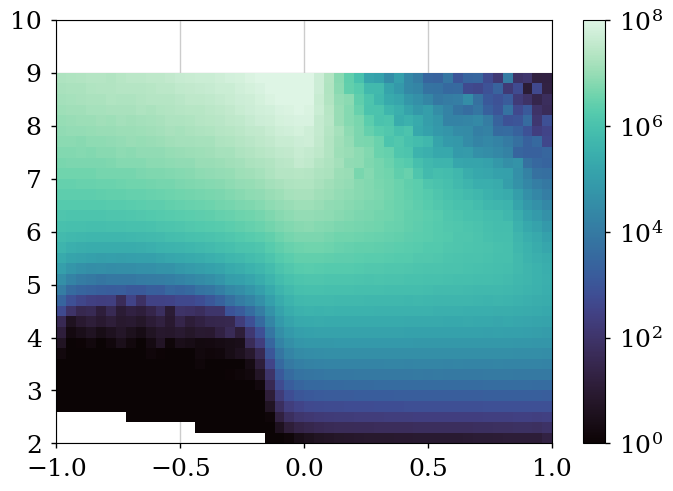

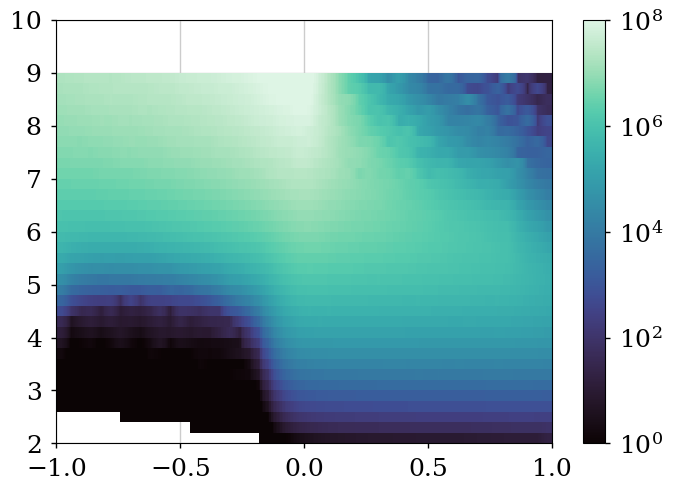

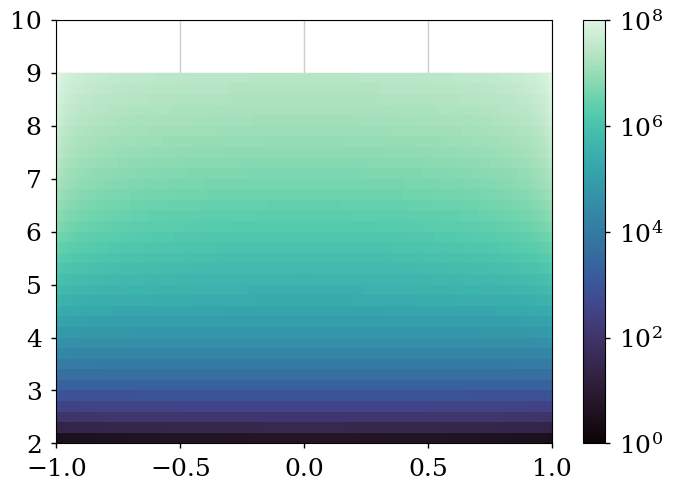

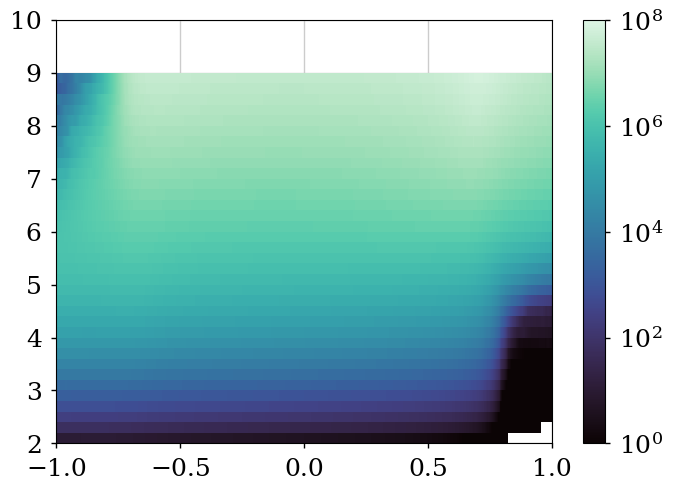

In [115]:
plt.figure()
plt.pcolormesh(
    sindec_mids, log_emids, aeff_icecube_full, norm=LogNorm(vmin=1, vmax=1e8)
)
plt.colorbar()

plt.figure()
plt.pcolormesh(
    _sd,
    log_emids,
    ic_aeff_2d,
    norm=LogNorm(vmin=1, vmax=1e8),
)
plt.colorbar()

plt.figure()
plt.pcolormesh(
    _sd,
    log_emids,
    new_aeff_2d,
    norm=LogNorm(vmin=1, vmax=1e8),
)
plt.colorbar()

plt.figure()
plt.pcolormesh(
    _sd,
    log_emids,
    tilted_aeff_2d,
    norm=LogNorm(vmin=1, vmax=1e8),
)
plt.colorbar()

np.max(aeff_icecube_full) / np.max(ic_aeff_2d)

-0.003135316872743082
-1.0
0.0
-0.9999901697881075


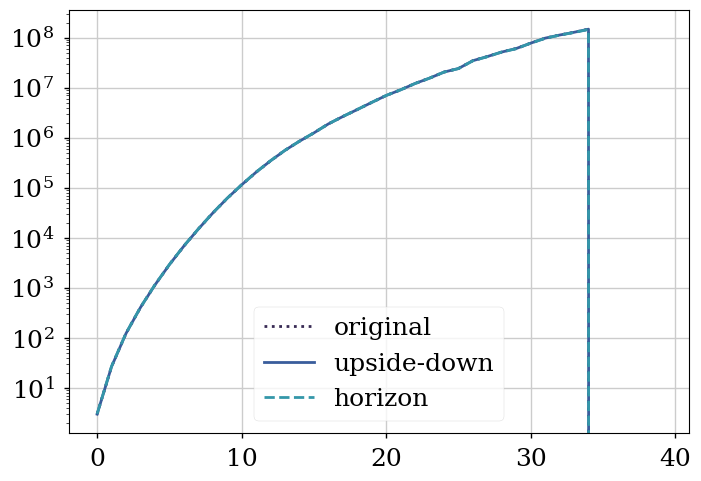

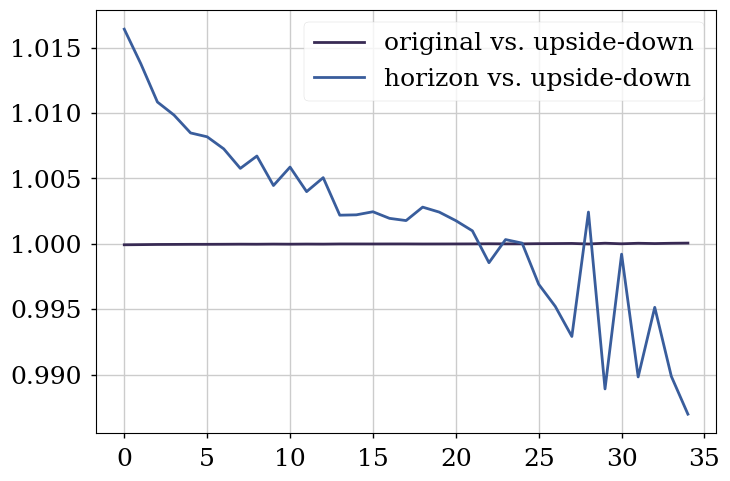

In [116]:
# plt.plot(aeff_icecube_full[:, 24:27], ":")
ind_mid = len(ic_aeff_2d.T) // 2
print(_sd_bins[ind_mid])
print(_sd_bins[0])
print(_sd[ind_mid])
print(_sd[0])

plt.plot(
    0.5 * (aeff_icecube_full[:, 24] + aeff_icecube_full[:, 25]), ":", label="original"
)
plt.plot(ic_aeff_2d[:, ind_mid], label="upside-down")
plt.plot(new_aeff_2d[:, 0], ls="--", label="horizon")
plt.yscale("log")
plt.legend()

plt.figure()
plt.plot(
    0.5
    * (aeff_icecube_full[:, 24] + aeff_icecube_full[:, 25])
    / ic_aeff_2d[:, ind_mid],
    label="original vs. upside-down",
)
plt.plot(new_aeff_2d[:, 0] / ic_aeff_2d[:, ind_mid], label="horizon vs. upside-down")
plt.legend()

## diffuse

In [117]:
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME,
    ewidth=ewidth,
    diff_or_ps="diff",
)

aeff_factor = calc_aeff_factor(aeff_icecube_full.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("original aeff and binning:", np.sum(k_s))


# rotated
diffuse_config = dict(
    sindec_mids=_sd,
    sindec_width=np.diff(_sd_bins),
    livetime=LIVETIME,
    ewidth=ewidth,
    diff_or_ps="diff",
)
aeff_factor = calc_aeff_factor(new_aeff_2d.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("rotated equatorial:", np.sum(k_s))

aeff_factor = calc_aeff_factor(ic_aeff_2d.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("rotated icecube:", np.sum(k_s))

aeff_factor = calc_aeff_factor(tilted_aeff_2d.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("rotated tilted:", np.sum(k_s))

original aeff and binning: 3190.520945849161
rotated equatorial: 3190.6835675898933
rotated icecube: 3190.5456871463807
rotated tilted: 3190.6216331894607


## ps

In [118]:
# ps - horizon vs pole
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=0, #30,
    diff_or_ps="ps"
)

aeff_factor_signal = calc_aeff_factor(aeff_icecube_full.T, **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("original aeff and binning:", np.sum(k_s))

src_config = dict(
    sindec_mids=_sd_bins,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=0, 
    diff_or_ps="ps"
)


aeff_factor_signal = calc_aeff_factor(ic_aeff_2d.T, **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("rotated icecube:", np.sum(k_s))


src_config = dict(
    sindec_mids=_sd_bins,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=np.pi/2,
    diff_or_ps="ps"
)

aeff_factor_signal = calc_aeff_factor(new_aeff_2d.T, **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("rotated equatorial det:", np.sum(k_s))

original aeff and binning: 98.30373204928871
rotated icecube: 99.76999022313042
end of range
rotated equatorial det: 97.52596544548388


# re-binning

In [84]:
from mephisto import Mephistogram
import settings as st
print(st.sindec_width[:10])

[1.98183377e-05 5.94542275e-05 9.90877608e-05 1.38717367e-04
 1.78341474e-04 2.17958513e-04 2.57566912e-04 2.97165102e-04
 3.36751514e-04 3.76324578e-04]


In [57]:
aeff_interp = padded_interpolation(
    np.log(ic_aeff_2d),
    log_ebins,
    _sd_bins,
    bounds_error=True,
    method=interpolation_method,
)
ss, ll = np.meshgrid(st.sindec_mids, st.logE_mids)
aeff_tmp = np.exp(aeff_interp((ll, ss)))
aeff_tmp[np.isnan(aeff_tmp)] = 0
_aeff_m = Mephistogram(
            aeff_tmp.T ,
            (st.sindec_bins, st.logE_bins),
            ("sin(dec)", "log(E/GeV)"),
            make_hist=False,
        )

In [58]:
# ps 
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=0, #30,
    diff_or_ps="ps"
)

aeff_factor_signal = calc_aeff_factor(_aeff_m, **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print(np.sum(k_s))


# diffuse
diffuse_config = dict(
    sindec_mids=st.sindec_mids,
    sindec_width=st.sindec_width,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    diff_or_ps="diff",
)
aeff_factor = calc_aeff_factor(_aeff_m, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))

96.76406540877207
Signal: 3146.886350811806


## re-binned aeff

In [95]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])

with open(join(LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d_full = pickle.load(f)

dict_keys(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT', 'HUNT', 'NEON', 'Gen-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.78074661 13.78074661 17.17025443 ... 83.33396413 16.3500159
  12.61079183]
 [17.35356268 17.35356268 20.90487661 ... 40.49757513 16.86041072
  13.00446012]
 [19.16198283 19.16198283 22.79530306 ... 18.80376948 17.23165171
  13.29079885]]


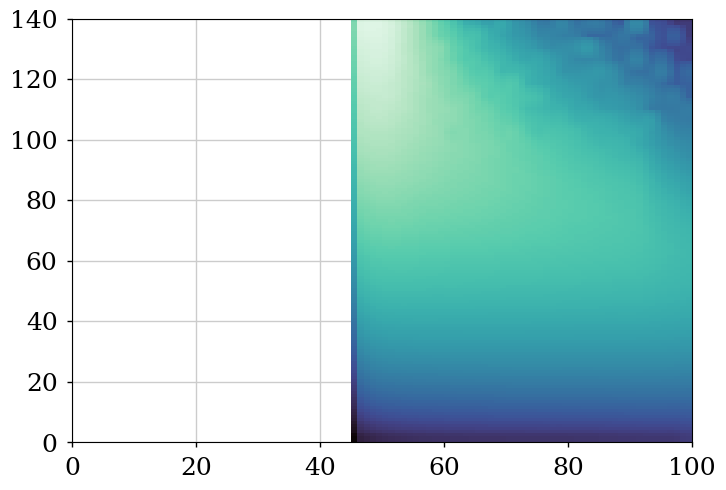

In [96]:
plt.pcolormesh(aeff_2d["IceCube"].histo.T, norm=LogNorm())

# horizon example

Signal: 53.2835270958942
-90.0 deg 90.0 deg
1.0
Signal: 53.283500846676525

-90.0 deg 0.0 deg
1.0
Signal: 53.28350084667653

90.0 deg 0.0 deg
1.0
Signal: 53.28350084671054

0.0 deg 90.0 deg
0.9999999999999998
Signal: 53.36403117677743

0.0 deg 0.0 deg
0.9999999999999999
Signal: 53.06716729743407

0.0 deg 120.0 deg
0.9999999999999997
Signal: 53.201485979233034



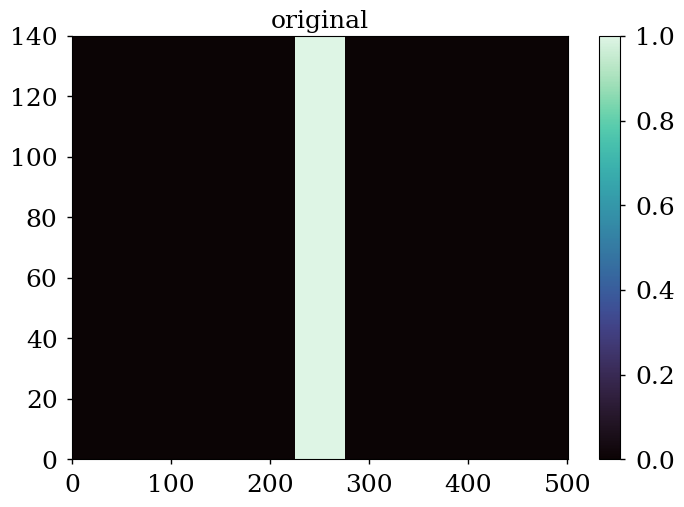

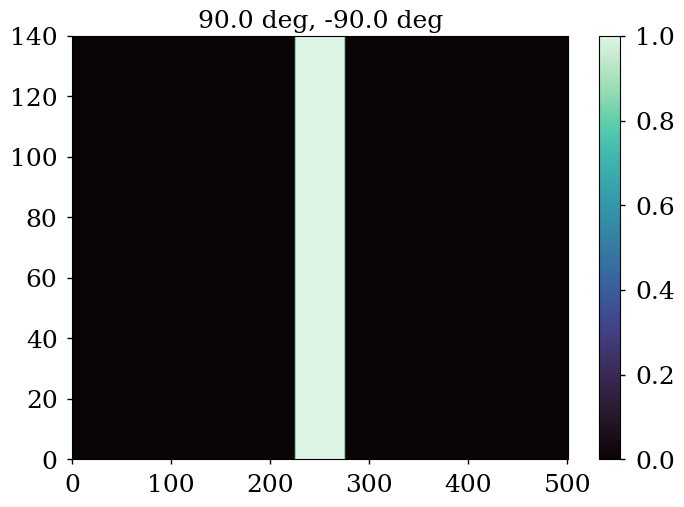

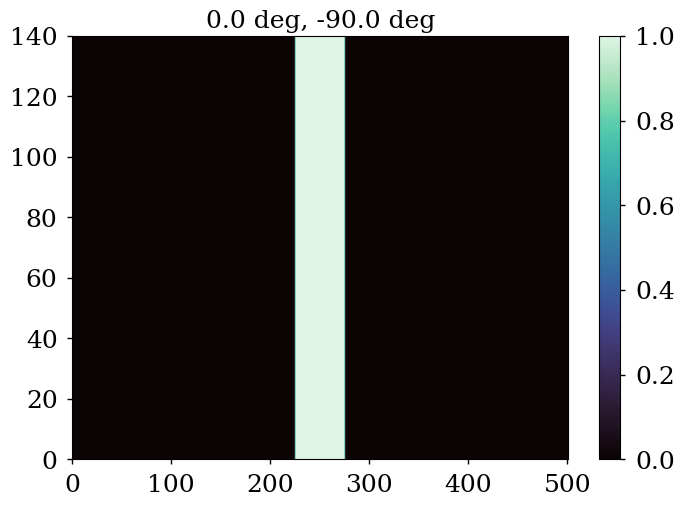

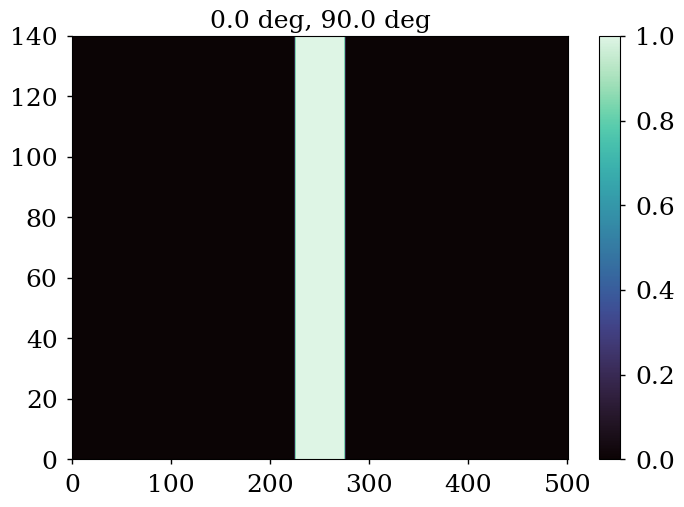

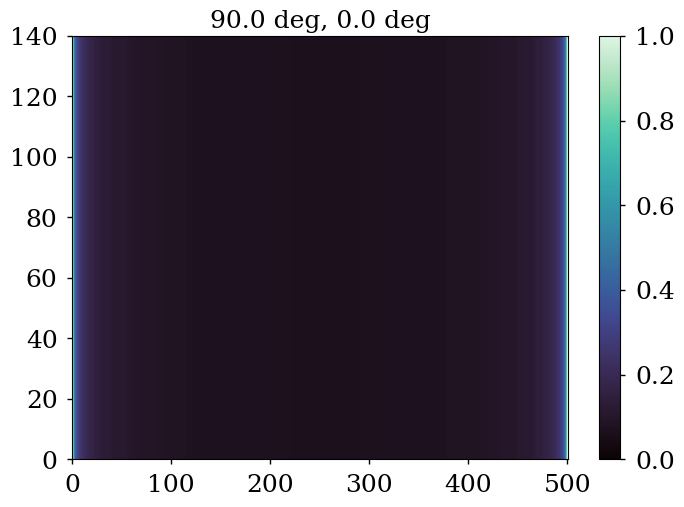

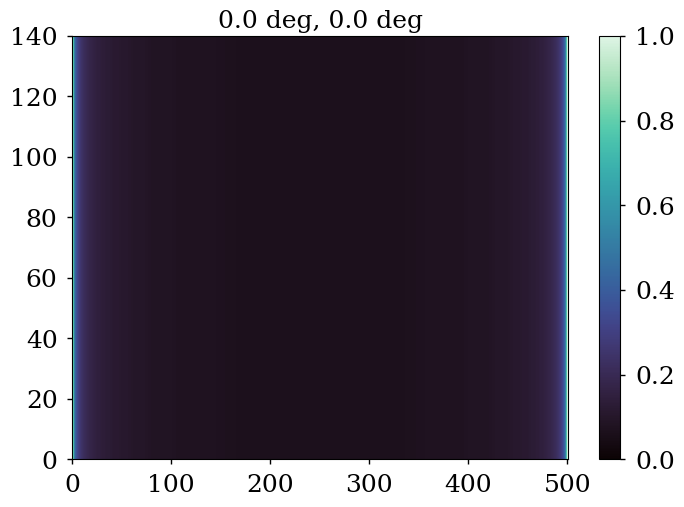

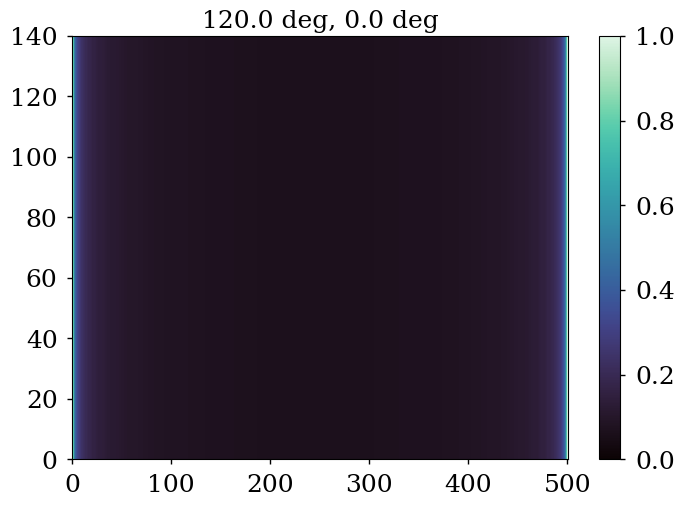

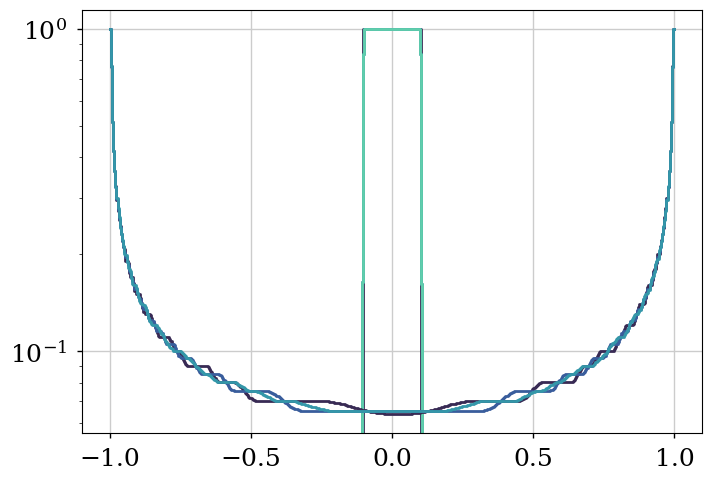

In [104]:
snum = 502
sindec_bins_test = np.linspace(-1, 1, snum)
sindec_mids_test = get_mids(sindec_bins_test)
sindec_width_test = np.diff(sindec_bins_test)
ra_bins_test = np.linspace(0, np.pi * 2, 200)
ra_mids_test = get_mids(ra_bins_test)
ra_width_test = np.diff(ra_bins_test)
# aeff_test = np.ones((len(st.emids), len(sindec_mids_test)))
aeff_test = np.zeros((len(st.emids), len(sindec_mids_test)))
mid_indx = (snum - 2) // 2
half_width = 25
aeff_test[:, mid_indx - half_width : mid_indx + half_width + 1] = 1

### diffuse flux

# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

diffuse_config = dict(
    sindec_mids=sindec_mids_test,
    sindec_width=sindec_width_test,
    livetime=LIVETIME * 100,
    ewidth=st.ewidth,
    diff_or_ps="diff",
)

ident = "IceCube"
aeff_factor = calc_aeff_factor(aeff_test.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))


plt.figure(3)
plt.plot(sindec_mids_test, aeff_test[1], ds="steps-mid")

plt.figure()
plt.pcolormesh(
    aeff_test,
    vmin=0,
)
plt.colorbar()
plt.title("original")


grid2d, eq_coords = setup_aeff_grid(
    aeff_test, sindec_mids_test, ra_mids_test, ra_width_test, log_int=False
)


# rotations
for lat, lon in zip(
    [-90 * u.deg, -90 * u.deg, 90 * u.deg, 0 * u.deg, 0 * u.deg, 0 * u.deg],
    [90 * u.deg, 0 * u.deg, 0 * u.deg, 90 * u.deg, 0 * u.deg, 120 * u.deg],
):
    print(lat, lon)
    aeff_horizon_test = aeff_rotation(
        lat,
        lon,
        eq_coords,
        grid2d,
        ra_width_test,
        log_aeff=False,
    )
    print(np.max(aeff_horizon_test))
    plt.figure(3)
    plt.plot(sindec_mids_test, aeff_horizon_test[1], ds="steps-mid")

    plt.figure()
    plt.title(f"{lon}, {lat}")
    plt.pcolormesh(aeff_horizon_test, vmin=0)
    plt.colorbar()

    aeff_factor = calc_aeff_factor(aeff_horizon_test.T, **diffuse_config)

    k_s = astro_flux(
        aeff_factor,
        st.emids,
        energy_resolution=None,
        phi_scaling=1,
        flux_shape=diffuse_flux,
    )

    print("Signal:", np.sum(k_s))
    print()
plt.figure(3)
plt.yscale("log")

In [ ]:
### diffuse flux

# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME *100,
    ewidth=ewidth,
    diff_or_ps="diff",
)

ident = "IceCube"
aeff_factor = calc_aeff_factor(aeff_test.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))



aeff_factor = calc_aeff_factor(aeff_horizon_test.T, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))



ValueError: operands could not be broadcast together with shapes (501,140) (100,1) 

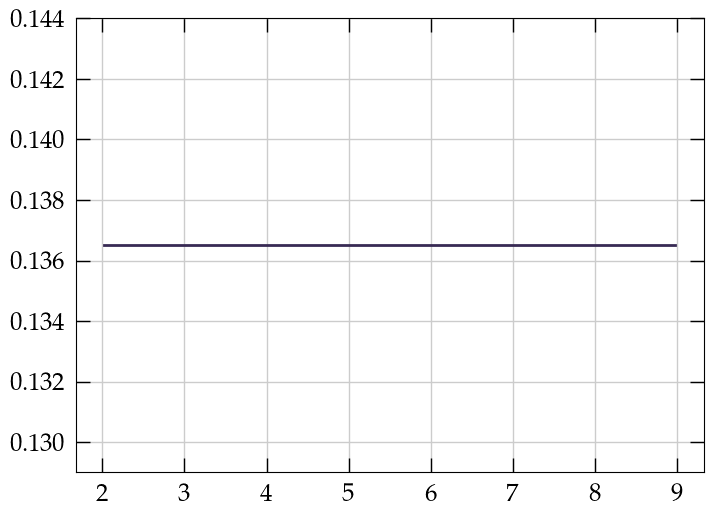

In [ ]:
plt.plot(st.logE_mids, aeff_horizon_test[:,-1]/aeff_test[:,50])


Text(0.5, 1.0, 'Effective area slices')

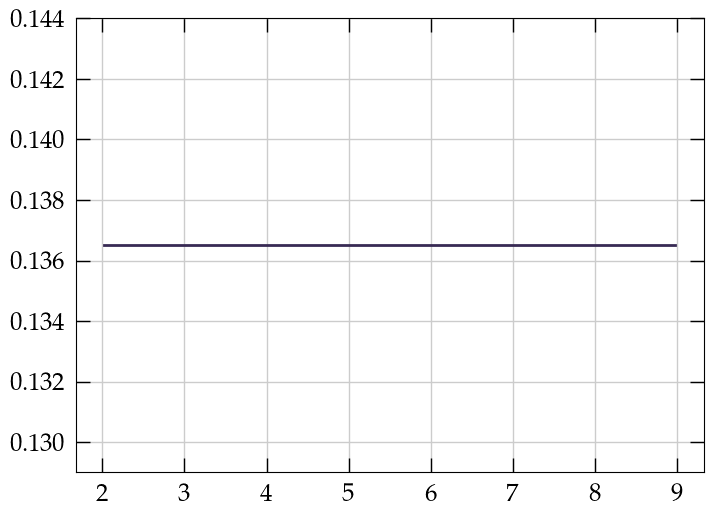

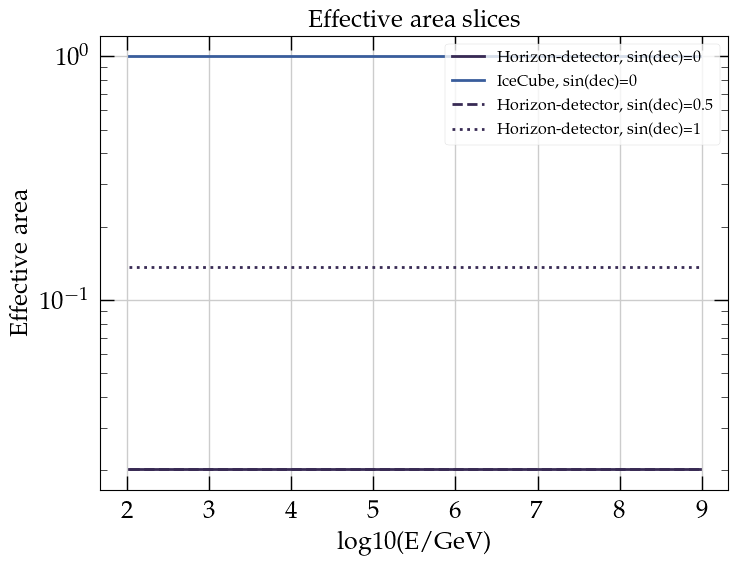

In [ ]:

plt.figure()
plt.plot(st.logE_mids, aeff_horizon_test[:,-1]/aeff_test[:,50])

plt.figure()
indx = 50

p1 = plt.plot(st.logE_mids, aeff_horizon_test[:, indx], label="Horizon-detector, sin(dec)=0")
p2 = plt.plot(
    st.logE_mids, aeff_test[:, indx], label="IceCube, sin(dec)=0"
)

indx = 75
_ = plt.plot(
    st.logE_mids,
    aeff_horizon_test[:, indx],
    label="Horizon-detector, sin(dec)=0.5",
    ls="--",
    color=p1[0].get_color(),
)

indx = -1
_ = plt.plot(
    st.logE_mids,
    aeff_horizon_test[:, indx],
    label="Horizon-detector, sin(dec)=1",
    ls=":",
    color=p1[0].get_color(),
)

plt.xlabel("log10(E/GeV)")
plt.ylabel("Effective area")

plt.yscale("log")
plt.legend(fontsize="small")
plt.title("Effective area slices")

### actual aeff

In [ ]:
grid2d, eq_coords = setup_aeff_grid(
        aeff_2d["IceCube"].histo.T, st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )
k = "Horizon"
aeff_horizon =  aeff_rotation(
    poles[k]["lat"],
    poles[k]["lon"],
    eq_coords,
    grid2d,
    ra_width,
    log_aeff=False,
)


In [ ]:
### point source
ident = "IceCube"

src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=0
)

aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10**st.logE_mids,
    energy_resolution=None,
    phi_scaling=10,
    flux_shape=txs_flux,
)
print("signal events:", np.sum(k_s))
### point source
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=1,
    dec=np.pi/2 # north pole
)

aeff_factor_signal = calc_aeff_factor(aeff_horizon.T, **src_config)

k_s_2 = astro_flux(
    aeff_factor_signal,
    10**st.logE_mids,
    energy_resolution=None,
    phi_scaling=10,
    flux_shape=txs_flux,
)
print("signal events:", np.sum(k_s_2))

print(np.sum(k_s_2)/np.sum(k_s))

signal events: 54.42372260906821
signal events: 37.6116180499489
0.6910886695516482


In [ ]:
### diffuse flux

# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME / 5,
    ewidth=ewidth,
    diff_or_ps="diff",
)

ident = "IceCube"
aeff_factor = calc_aeff_factor(aeff_2d[ident], **diffuse_config)

# asimov data
# in reconstructed energy
k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))



aeff_factor = calc_aeff_factor(aeff_horizon.T, **diffuse_config)

# asimov data
# in reconstructed energy
k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

print("Signal:", np.sum(k_s))



Signal: 597.4751758813305
Signal: 597.5585922549367


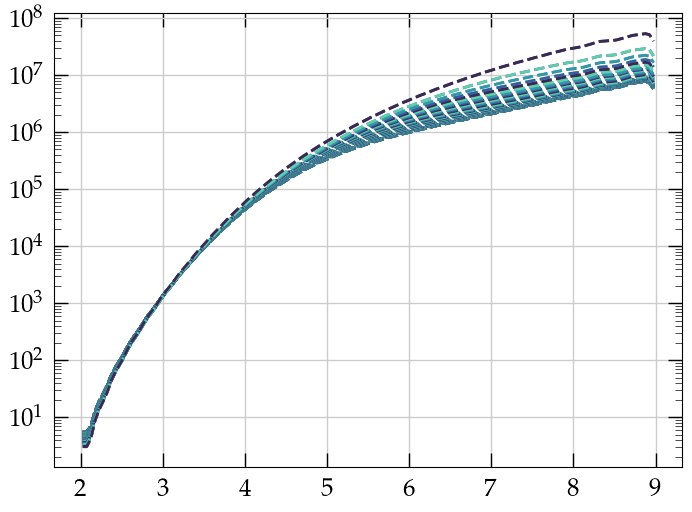

In [ ]:
_ = plt.plot(st.logE_mids, aeff_horizon, label="Horizon-detector, sin(dec)=0.5", ls="--")
plt.yscale("log")


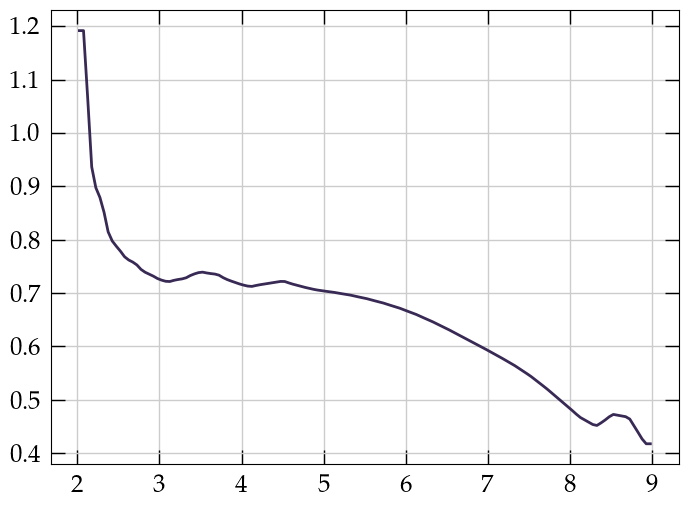

In [ ]:
plt.plot(st.logE_mids, aeff_horizon[:,-1]/aeff_2d["IceCube"].histo[50].T)


In [ ]:
indx = 50

p1 = plt.plot(st.logE_mids, aeff_horizon[:, indx], label="Horizon-detector, sin(dec)=0")
p2 = plt.plot(
    st.logE_mids, aeff_2d["IceCube"].histo[indx].T, label="IceCube, sin(dec)=0"
)

indx = 75
_ = plt.plot(
    st.logE_mids,
    aeff_horizon[:, indx],
    label="Horizon-detector, sin(dec)=0.5",
    ls="--",
    color=p1[0].get_color(),
)
_ = plt.plot(
    st.logE_mids,
    aeff_2d["IceCube"].histo[indx].T,
    label="IceCube, sin(dec)=0.5",
    ls="--",
    color=p2[0].get_color(),
)

indx = -1
_ = plt.plot(
    st.logE_mids,
    aeff_horizon[:, indx],
    label="Horizon-detector, sin(dec)=1",
    ls=":",
    color=p1[0].get_color(),
)
_ = plt.plot(
    st.logE_mids,
    aeff_2d["IceCube"].histo[indx].T,
    label="IceCube, sin(dec)=1",
    ls=":",
    color=p2[0].get_color(),
)

plt.xlabel("log10(E/GeV)")
plt.ylabel("Effective area")

plt.yscale("log")
plt.legend(fontsize="small")
plt.title("Effective area slices")

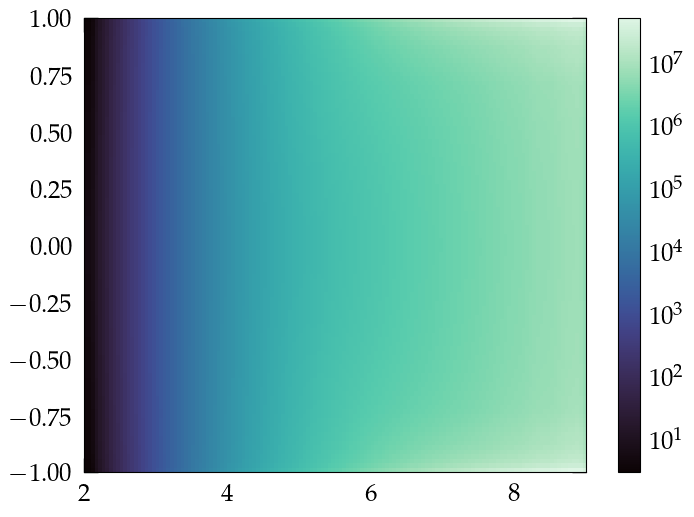

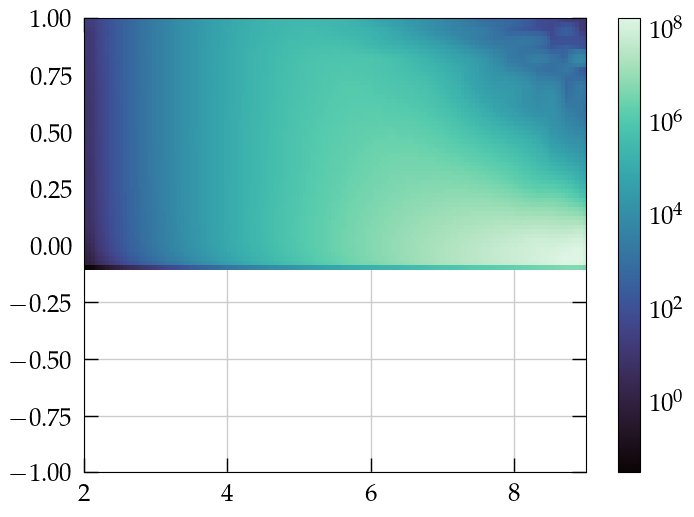

In [ ]:
plt.figure()
plt.pcolormesh(st.logE_bins, st.sindec_bins, aeff_horizon.T, norm=LogNorm())
plt.colorbar()

plt.figure()
plt.pcolormesh(st.logE_bins, st.sindec_bins, aeff_2d["IceCube"].histo, norm=LogNorm())
plt.colorbar()

# Additional effective area checking plots

In [ ]:
from tools import reset_palette

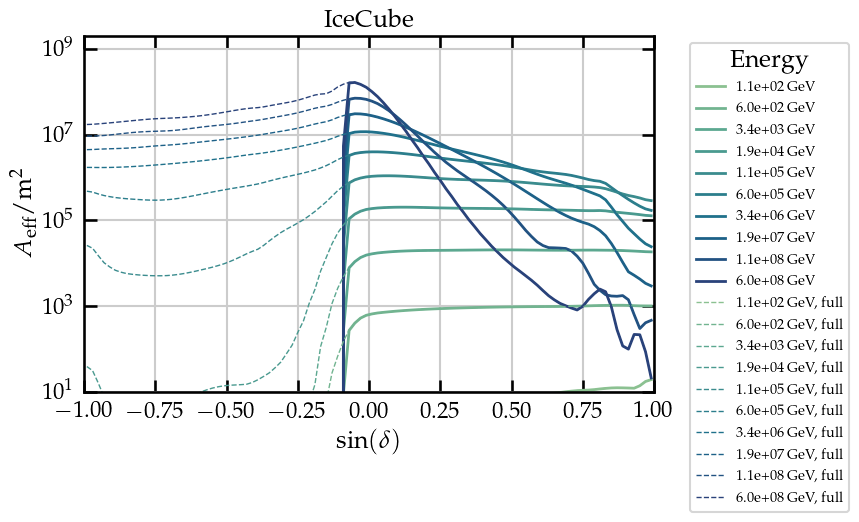

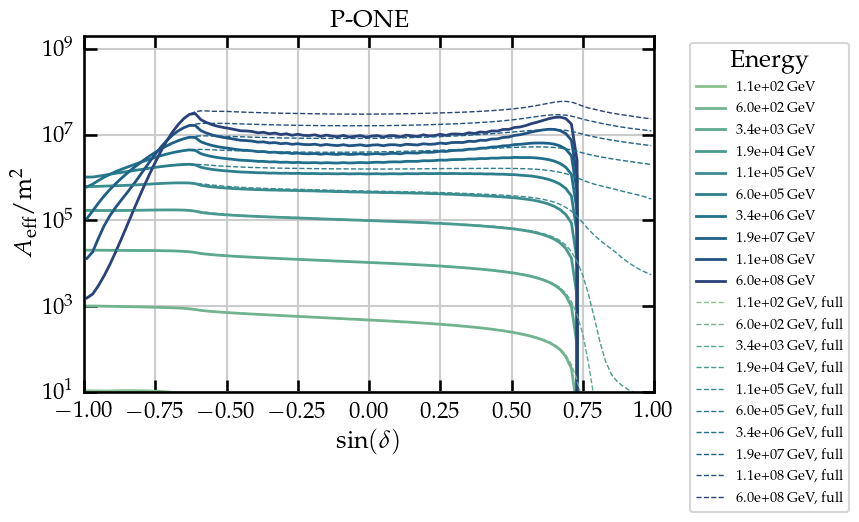

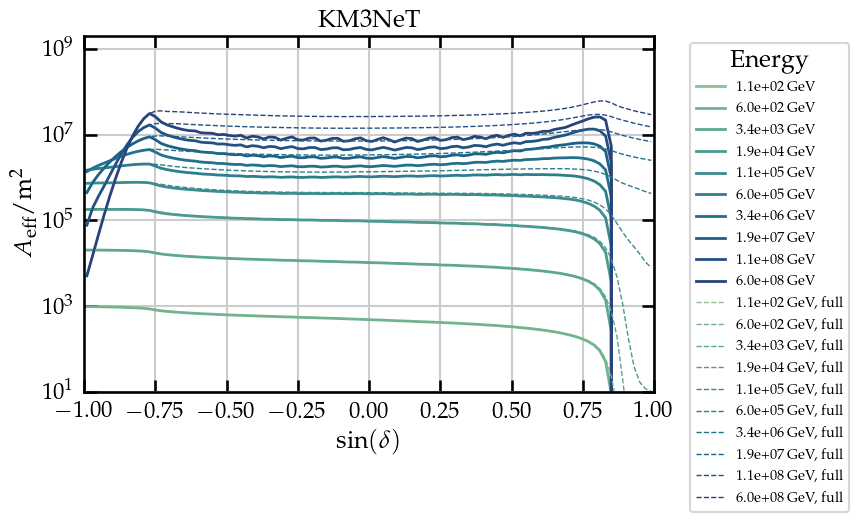

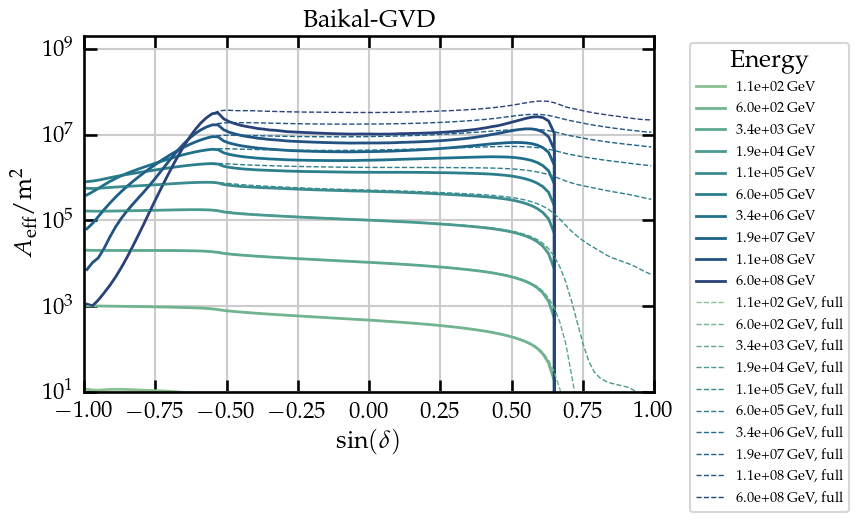

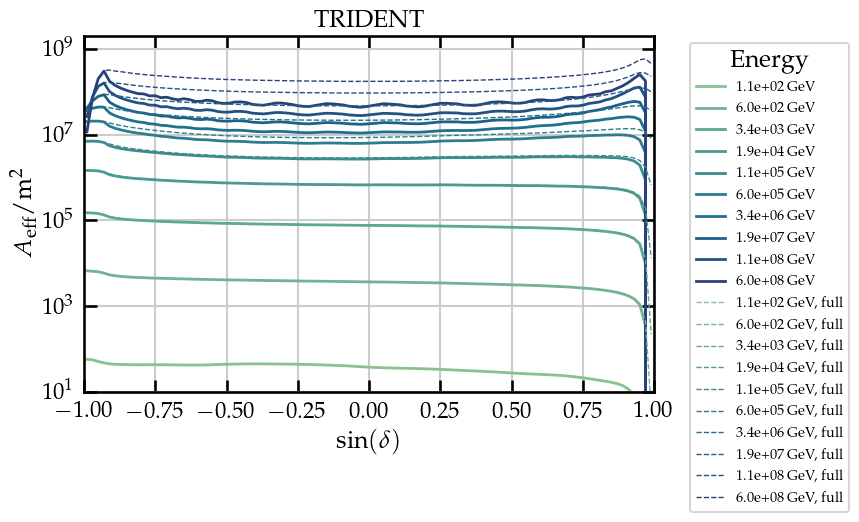

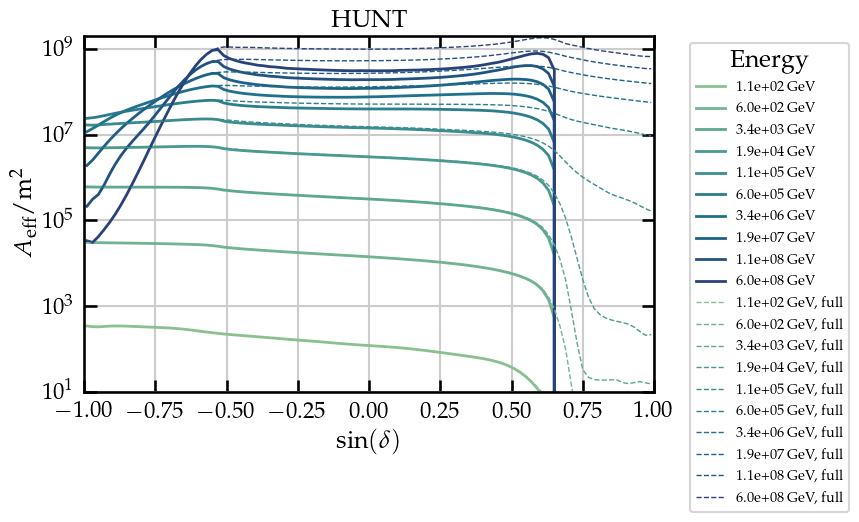

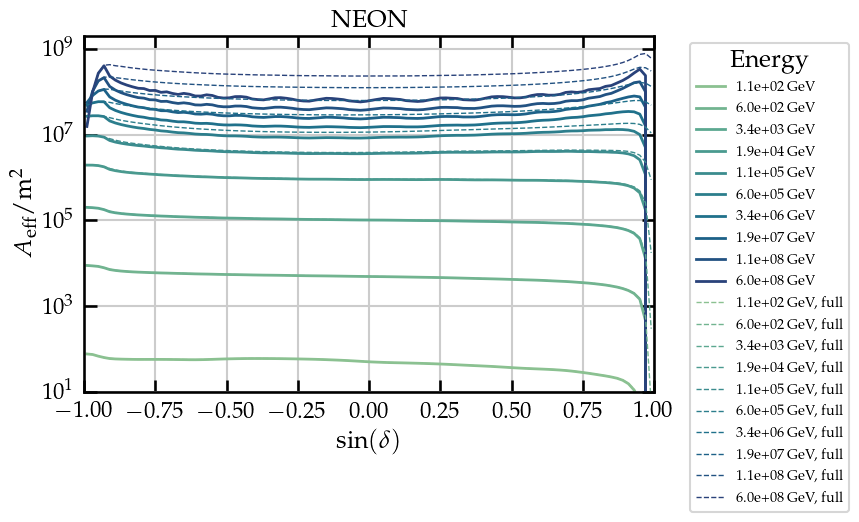

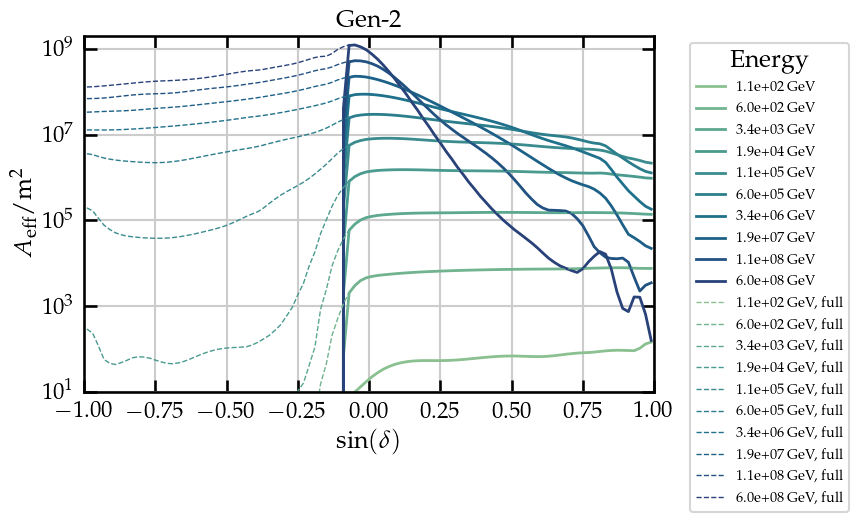

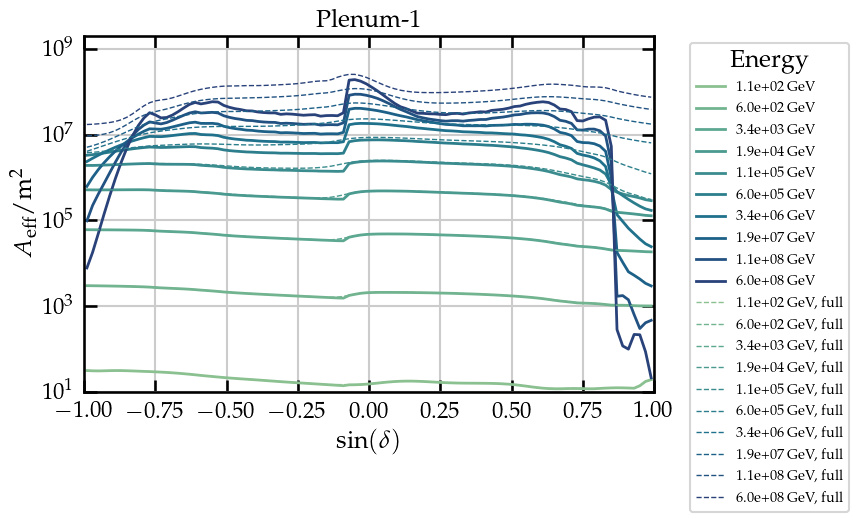

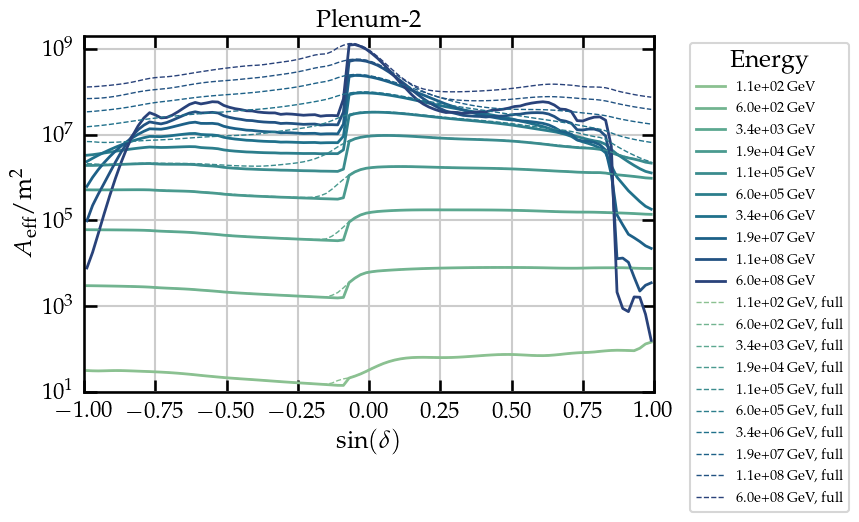

In [ ]:
# slices in energy
factor = 15
nlines = len(emids) // factor + 1
reset_palette(nlines, sns)
mid_color = plt.rcParams["axes.prop_cycle"].by_key()["color"][nlines // 2]
for k in aeff_2d:
    plt.figure(figsize=(9, 5))
    for ie, ae in enumerate(aeff_2d[k].T()[::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV",
            ls="-",  # rotated
            lw=2,
        )
    for ie, ae in enumerate(aeff_2d_full[k].T()[::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV, full",
            ls="--",  # rotated
            lw=1,
        )
    plt.yscale("log")
    plt.title(k)

    plt.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", title="Energy", fontsize="xx-small"
    )
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(10, 2e9)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
